In [1]:
import numpy as np
from pulp import LpProblem, LpMinimize, LpVariable, LpMaximize
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
ge = np.vectorize(lambda x, y: x >= y)
le = np.vectorize(lambda x, y: x <= y)

# Решение симплекс-методом
def get_mixed_strategy(M, F_type, C_type_f):
    model = LpProblem("Game", F_type)
    W = []

    for i in range(M.shape[0]):
        w = LpVariable(f'w{i+1}', lowBound=0)
        W.append(w)

    W = np.array(W)

    F = (W).sum()
    C = C_type_f((M * W).sum(axis=1), 1)

    model += F
    for constraint in C:
        model += constraint

    model.solve()

    opt = np.array(list(map(lambda x: x.value(), model.variables())))

    v = 1 / opt.sum()
    opt = opt / opt.sum()
    return opt, v

#### 1. Решение задачи о нахождении выигрышной стратегии для антагонистической игры

In [3]:
def solve_matrix_game(strategies_A, strategies_B, M):
    worst_response_scenarios_A = M.min(axis=1)
    worst_response_scenarios_B = M.max(axis=0)
    opt_strategy_A = worst_response_scenarios_A.argmax() # alpha - нижняя цена игры (максимин) - Это максимальный выигрыш игрока A
    opt_strategy_B = worst_response_scenarios_B.argmin() # beta - верхняя цена игры (минимакс) - Это максимальный проигрыш игрока В

    opt, v = get_mixed_strategy(M, LpMaximize, le)

    res = f'a) Оптимальная чистая стратегия для игрока А: №{opt_strategy_A + 1} - {strategies_A[opt_strategy_A]}\n' \
      f'б) Цена игры для игрока А при выборе чистой оптимальной стратегии:  {worst_response_scenarios_A[opt_strategy_A]}\n' \
      f'в) Оптимальная чистая стратегия для игрока Б: №{opt_strategy_B + 1} - {strategies_B[opt_strategy_B]}\n' \
      f'г) Цена игры для игрока Б при выборе чистой оптимальной стратегии: {worst_response_scenarios_B[opt_strategy_B]}\n' \
      f'д) Таблица смешанных стратегий для игрока А: {opt}\n' \
      f'е) Цена игры для игрока А при выборе смешанной оптимальной стратегии: {v}'

    print(res)

In [4]:
strategies_A = ['Телефоны','Ноутбуки', 'ПК']
strategies_B = ['Телефоны', 'Наушники', 'Ноутбуки']

# Матрица игры
M = np.array([
    [300, 280, 230],
    [200, 180, 130],
    [240, 380, 400]
])

In [5]:
solve_matrix_game(strategies_A, strategies_B, M)

a) Оптимальная чистая стратегия для игрока А: №3 - ПК
б) Цена игры для игрока А при выборе чистой оптимальной стратегии:  240
в) Оптимальная чистая стратегия для игрока Б: №1 - Телефоны
г) Цена игры для игрока Б при выборе чистой оптимальной стратегии: 300
д) Таблица смешанных стратегий для игрока А: [0.73913043 0.         0.26086957]
е) Цена игры для игрока А при выборе смешанной оптимальной стратегии: 281.73912932742536


### 2.	Решение задачи о нахождении выигрышной стратегии для биматричной игры

In [102]:
def solve_bimatrix_game(strategies_A, strategies_B, M_A, M_B):
    best_scenarios_A = M_A.max(axis=0)
    worst_from_best_scenarios_A = best_scenarios_A.argmin()
    worst_scenarios_B = M_B.min(axis=0)
    best_from_worst_scenarios_B = worst_scenarios_B.argmax()
    v_A = best_scenarios_A[worst_from_best_scenarios_A]
    v_B = worst_scenarios_B[best_from_worst_scenarios_B]
    v_total = v_A + v_B

    P = get_mixed_strategy(M_B, LpMinimize, ge)[0]
    Q = get_mixed_strategy(M_A, LpMaximize, le)[0]

    v_mixed_A = ((P * M_A.T).T * Q).sum()
    v_mixed_B = ((P * M_B.T).T * Q).sum()
    v_mixed_total = v_mixed_A + v_mixed_B

    import nashpy as nash
    nash_balances = list(nash.Game(M_A, M_B).support_enumeration())
    print(nash_balances)

    res = f"а) Оптимальная чистая стратегия для игрока А: №{worst_from_best_scenarios_A + 1} - {strategies_A[worst_from_best_scenarios_A]}\n" \
          f"б) Цена игры для игрока А при выборе чистой оптимальной стратегии: {v_A}\n" \
          f"в) Оптимальная чистая стратегия для игрока Б: №{best_from_worst_scenarios_B + 1} - {strategies_B[best_from_worst_scenarios_B]}\n" \
          f"г) Цена игры для игрока Б при выборе чистой оптимальной стратегии: {v_B}\n" \
          f"д) Общая (суммарная) цена игры: {v_total}\n" \
          f"е) Количество равновесий по Нэшу: {len(nash_balances)}\n" \
          f"е) Таблица смешанных стратегий для компании А: {P}\n" \
          f"ж) Цена игры для игрока А при выборе смешанной оптимальной стратегии: {v_mixed_A}\n" \
          f"з) Таблица смешанных стратегий для компании Б: {Q}\n" \
          f"и) Цена игры для игрока Б при выборе смешанной оптимальной стратегии: {v_mixed_B}\n" \
          f"к) Общая цена игры в случае использования оптимальных стратегий: {v_mixed_total}\n"

    print(res)

In [103]:
# в) матрица весовых коэффициентов для игрока A;
M_A = np.array([
    [300, 280, 230],
    [200, 180, 130],
    [240, 380, 400],
])

# г) матрица весовых коэффициентов для игрока Б;
M_B = np.array([
    [180, 110, 240],
    [120, 160, 210],
    [300, 140, 250],
])

In [104]:
solve_bimatrix_game(strategies_A, strategies_B, M_A, M_B)

[(array([0.45454545, 0.        , 0.54545455]), array([0.73913043, 0.        , 0.26086957]))]
а) Оптимальная чистая стратегия для игрока А: №1 - Телефоны
б) Цена игры для игрока А при выборе чистой оптимальной стратегии: 300
в) Оптимальная чистая стратегия для игрока Б: №3 - Ноутбуки
г) Цена игры для игрока Б при выборе чистой оптимальной стратегии: 210
д) Общая (суммарная) цена игры: 510
е) Количество равновесий по Нэшу: 1
е) Таблица смешанных стратегий для компании А: [0. 0. 1.]
ж) Цена игры для игрока А при выборе смешанной оптимальной стратегии: 281.73913045438184
з) Таблица смешанных стратегий для компании Б: [0.73913043 0.         0.26086957]
и) Цена игры для игрока Б при выборе смешанной оптимальной стратегии: 286.9565217330057
к) Общая цена игры в случае использования оптимальных стратегий: 568.6956521873875



### 3.	Решение задачи о принятии оптимального решения в условиях риска

In [9]:
def solve_game_with_environment(strategies_A, states, M, P):
    q = 1 / P.shape[0]
    lapplas_criterion = (M * q).sum(axis=1)
    lapplas_criterion_opt_v = lapplas_criterion.max()
    lapplas_criterion_opt = np.argwhere(lapplas_criterion == lapplas_criterion_opt_v).reshape(-1)
    lapplas_criterion_opt_strategies = ', '.join(map(lambda x: f'№{x+1} - {strategies_A[x]}', lapplas_criterion_opt))

    bayes_criterion = (M * P).sum(axis=1)
    bayes_criterion_opt = bayes_criterion.argmax()
    bayes_criterion_opt_v = bayes_criterion[bayes_criterion_opt]

    hermeyer_criterion = (M * P).min(axis=1)
    hermeyer_criterion_opt = hermeyer_criterion.argmax()
    min_j = (M * P).argmin(axis=1)[hermeyer_criterion_opt]
    hermeyer_criterion_opt_v = hermeyer_criterion[hermeyer_criterion_opt]

    mixed_opt, mixed_opt_v = get_mixed_strategy((M * P).T, LpMinimize, ge)

    res = f"а) Оптимальная стратегия игрока А по критерию Лапласа: {lapplas_criterion_opt_strategies}\n" \
      f"б) Цена игры с оптимальной стратегии по критерию Лапласа: {lapplas_criterion_opt_v}\n" \
      f"в) Оптимальная стратегия игрока А по критерию Баеса: №{bayes_criterion_opt + 1} - {strategies_A[bayes_criterion_opt]}\n" \
      f"г) Цена игры с оптимальной стратегии по критерию Баеса: {bayes_criterion_opt_v}\n" \
      f"д) Оптимальная чистая стратегия игрока А по критерию Гермейера: №{hermeyer_criterion_opt + 1} - {strategies_A[hermeyer_criterion_opt]}\n" \
      f"е) Цена игры с оптимальной чистой стратегии по критерию Гермейера: {hermeyer_criterion_opt_v} / {M[hermeyer_criterion_opt, min_j]}\n" \
      f"ж) Таблица оптимальных смешанных стратегий для игрока А по критерию Гермейера: {mixed_opt}\n" \
      f"з) Цена игры для игрока А при выборе смешанной оптимальной стратегии по критерию Гермейера: {mixed_opt_v} / {((M * P).T * mixed_opt).sum()}\n"

    print(res)


In [10]:
# Стратегии
strategies_A = ["Продукты", "Косметика", "Одежда", "Бытовая химия"]

# Состояния природы
states = ["Рецессия", "Стагнация", "Оживление", "Подъем"]

# Матрица коэффициентов
M = np.array([
    [50, 30, 35, 45],
    [40, 40, 55, 40],
    [35, 40, 45, 55],
    [10, 20, 25, 35]
])

# Вектор вероятности
P = np.array([0.15, 0.25, 0.5, 0.1])

In [11]:
solve_game_with_environment(strategies_A, states, M, P)

а) Оптимальная стратегия игрока А по критерию Лапласа: №2 - Косметика, №3 - Одежда
б) Цена игры с оптимальной стратегии по критерию Лапласа: 43.75
в) Оптимальная стратегия игрока А по критерию Баеса: №2 - Косметика
г) Цена игры с оптимальной стратегии по критерию Баеса: 47.5
д) Оптимальная чистая стратегия игрока А по критерию Гермейера: №3 - Одежда
е) Цена игры с оптимальной чистой стратегии по критерию Гермейера: 5.25 / 35
ж) Таблица оптимальных смешанных стратегий для игрока А по критерию Гермейера: [0.07692307 0.         0.92307693 0.        ]
з) Цена игры для игрока А при выборе смешанной оптимальной стратегии по критерию Гермейера: 5.42307680898373 / 42.76923078487425



### 4.	Решение задачи о принятии оптимального решения в условиях неопределенности;

In [12]:
def solve_game_with_uncertainty(strategies_A, states, M, P):

    # Критерий пессимизма
    pessimism_criterion = M.min(axis=1)
    pessimism_criterion_opt_v = pessimism_criterion.min()
    pessimism_criterion_opt = np.argwhere(pessimism_criterion == pessimism_criterion_opt_v).reshape(-1)
    pessimism_criterion_opt_strategies = ', '.join(map(lambda x: f'№{x+1} - {strategies_A[x]}', pessimism_criterion_opt))

    # Критерий оптимизма
    optimism_criterion = M.max(axis=1)
    optimism_criterion_opt_v = optimism_criterion.max()
    optimism_criterion_opt = np.argwhere(optimism_criterion == optimism_criterion_opt_v).reshape(-1)
    optimism_criterion_opt_strategies = ', '.join(map(lambda x: f'№{x+1} - {strategies_A[x]}', optimism_criterion_opt))



    # Критерий Сэвиджа
    R = M.max(axis=0) - M # матрица рисков
    savage_criterion = R.max(axis=1)
    savage_criterion_opt_v = savage_criterion.min()
    savage_criterion_opt = np.argwhere(savage_criterion == savage_criterion_opt_v).reshape(-1)
    savage_criterion_opt_strategies = ', '.join(map(lambda x: f'№{x+1} - {strategies_A[x]}', savage_criterion_opt))


    # Критерий Гурвица
    def show_diagram():
        diagram = conv[A].plot.bar()
        diagram.set_xlabel("Величина склонности к риску")
        diagram.set_ylabel("Цена игры")
        plt.plot(10 * conv.index, conv['max'], color="black", label='max')
        diagram.legend()
        return diagram


    A = list([f'A{i + 1}' for i in range(M.shape[0])])

    conv = pd.DataFrame(columns= A + ['max'], index=np.arange(0, 1 + 0.1, 0.1))

    for alpha in conv.index:
        conv.loc[alpha, A] = alpha * M.max(axis=1) + (1 - alpha) * M.min(axis=1)
    conv.index.name = "alpha"
    conv['max'] = conv[A].max(axis=1)

    # Критерий Вальда
    wald_criterion = M.min(axis=1)
    wald_criterion_opt_v = wald_criterion.max()
    wald_criterion_opt = np.argwhere(wald_criterion == wald_criterion_opt_v).reshape(-1)
    wald_criterion_opt_strategies = ', '.join(map(lambda x: f'№{x+1} - {strategies_A[x]}', wald_criterion_opt))




    res = f"а) Оптимальная стратегия игрока А по критерию пессимизма: {pessimism_criterion_opt_strategies}\n" \
          f"б) Цена игры оптимальной стратегии по критерию пессимизма: {pessimism_criterion_opt_v}\n" \
          f"в) Оптимальная стратегия игрока А по критерию оптимизма: {optimism_criterion_opt_strategies} \n" \
          f"г) Цена игры оптимальной стратегии по критерию оптимизма: {optimism_criterion_opt_v}\n" \
          f"д) Оптимальная стратегия игрока А по критерию Вальда: {wald_criterion_opt_strategies}\n" \
          f"е) Цена игры оптимальной стратегии по критерию Вальда: {wald_criterion_opt_v}\n" \
          f"ж) Линейная свертка склонности к риску по критерию Гурвица: \n{conv}\n" \
          f"з) Гистограмма (диаграмма) максимумов линейной свертки по критерию Гурвица:\n {show_diagram()} \n" \
          f"и) Оптимальная стратегия игрока А по критерию Сэвиджа: {savage_criterion_opt_strategies}\n" \
          f"к) Величина минимальной недополученной прибыли по критерию Сэвиджа: {savage_criterion[savage_criterion > savage_criterion_opt_v].min() - savage_criterion_opt_v}\n"

    print(res)


а) Оптимальная стратегия игрока А по критерию пессимизма: №4 - Бытовая химия
б) Цена игры оптимальной стратегии по критерию пессимизма: 10
в) Оптимальная стратегия игрока А по критерию оптимизма: №2 - Косметика, №3 - Одежда 
г) Цена игры оптимальной стратегии по критерию оптимизма: 55
д) Оптимальная стратегия игрока А по критерию Вальда: №2 - Косметика
е) Цена игры оптимальной стратегии по критерию Вальда: 40
ж) Линейная свертка склонности к риску по критерию Гурвица: 
         A1    A2    A3    A4   max
alpha                              
0.0    30.0  40.0  35.0  10.0  40.0
0.1    32.0  41.5  37.0  12.5  41.5
0.2    34.0  43.0  39.0  15.0  43.0
0.3    36.0  44.5  41.0  17.5  44.5
0.4    38.0  46.0  43.0  20.0  46.0
0.5    40.0  47.5  45.0  22.5  47.5
0.6    42.0  49.0  47.0  25.0  49.0
0.7    44.0  50.5  49.0  27.5  50.5
0.8    46.0  52.0  51.0  30.0  52.0
0.9    48.0  53.5  53.0  32.5  53.5
1.0    50.0  55.0  55.0  35.0  55.0
з) Гистограмма (диаграмма) максимумов линейной свертки по 

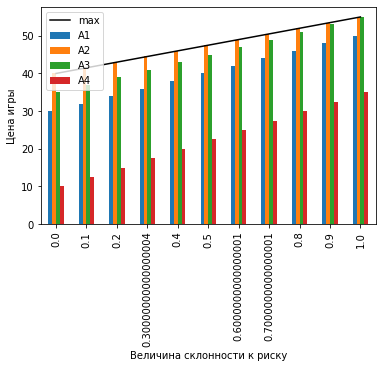

In [13]:
solve_game_with_uncertainty(strategies_A, states, M ,P)